In [1]:
import pandas as pd
from tqdm import tqdm

import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import emoji

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf

In [3]:
parameters = {}
parameters['classes'] = ['anger', 'joy', 'sadness', 'fear']
parameters['save_path'] = 'models/wassa_lstm_without_embedding/'

In [4]:
base_path = '../Data/wassa_data/'

In [5]:
class_mapping = {}
for idx, name in enumerate(parameters['classes']):
    class_mapping[name] = idx 
no_classes = len(parameters['classes'])

In [6]:
cols = ['tweet', 'tweettype']

In [7]:
stop = stopwords.words('english')

In [8]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                   "can't've": "cannot have", "'cause": "because", "could've": "could have", 
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
                   "he'll've": "he will have", "he's": "he is", "how'd": "how did", 
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                   "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
                   "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                   "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                   "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                   "this's": "this is",
                   "that'd": "that would", "that'd've": "that would have","that's": "that is", 
                   "there'd": "there would", "there'd've": "there would have","there's": "there is", 
                       "here's": "here is",
                   "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                   "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                   "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                   "we're": "we are", "we've": "we have", "weren't": "were not", 
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                   "what's": "what is", "what've": "what have", "when's": "when is", 
                   "when've": "when have", "where'd": "where did", "where's": "where is", 
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                   "who's": "who is", "who've": "who have", "why's": "why is", 
                   "why've": "why have", "will've": "will have", "won't": "will not", 
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                   "you'll've": "you will have", "you're": "you are", "you've": "you have" } 

In [9]:
import codecs
import unidecode
import re
import spacy
nlp = spacy.load('en')

def spacy_cleaner(text):
    try:
        decoded = unidecode.unidecode(codecs.decode(text, 'unicode_escape'))
    except:
        decoded = unidecode.unidecode(text)
    apostrophe_handled = re.sub("’", "'", decoded)
    expanded = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in apostrophe_handled.split(" ")])
    parsed = nlp(expanded)
    final_tokens = []
    for t in parsed:
        if t.is_punct or t.is_space or t.like_num or t.like_url or str(t).startswith('@'):
            pass
        else:
            if t.lemma_ == '-PRON-':
                final_tokens.append(str(t))
            else:
                sc_removed = re.sub("[^a-zA-Z]", '', str(t.lemma_))
                if len(sc_removed) > 1:
                    final_tokens.append(sc_removed)
    joined = ' '.join(final_tokens)
    spell_corrected = re.sub(r'(.)\1+', r'\1\1', joined)
    return spell_corrected

In [10]:
def clean_text(data):
    data = (re.sub(r"(#[\d\w\.]+)", '', data)).lower()
    data = emoji.demojize(data)
    data = spacy_cleaner(data)
    return data

In [11]:
def build_dataset(df, feature='text', target='label'):
    dataset = (
                tf.data.Dataset.from_tensor_slices(
                    (
                        tf.cast(df[feature].values, tf.string),
                        tf.cast(df[target].values, tf.int32)
                    )
                )
            )
    return dataset

In [12]:
def load_dataset(directory, ending, threshold = 0, testing = False):

    df_list = []

    for emotion in parameters['classes']:
        file_name = f'{base_path}{directory}/{emotion}{ending}'
        df = pd.read_csv(file_name, delimiter='\t')
        
        if not testing:
            df = df[df['score'] > threshold]
        
        df = df[cols]
        
        df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
        df['tweet'] = df['tweet'].apply(clean_text)        
        df['tweettype'] = df['tweettype'].apply(lambda x : class_mapping[x])        

        df_list.append(df)

    df = pd.concat(df_list)
    df = df.rename(columns = {'tweet' : 'text', 'tweettype' : 'label'})
    print('Distribution of data: ')
    print(df['label'].value_counts())
    
    labels = df['label'].values
    
    dataset = build_dataset(df)
    
    return dataset, labels

In [13]:
# Training
threshold = 0

directory = 'training'
ending = '-ratings-0to1.train.txt'

train_dataset,_ = load_dataset(directory, ending, threshold = threshold)

Distribution of data: 
3    1147
0     857
1     823
2     786
Name: label, dtype: int64


In [14]:
# Validation

directory = 'validation'
ending = '-ratings-0to1.dev.gold.txt'

val_dataset,_ = load_dataset(directory, ending)

Distribution of data: 
3    110
0     84
1     79
2     74
Name: label, dtype: int64


In [15]:
# Testing

directory = 'testing'
ending = '-ratings-0to1.test.target.txt'

test_dataset, y_test = load_dataset(directory, ending, testing = True)

Distribution of data: 
3    995
0    760
1    714
2    673
Name: label, dtype: int64


In [16]:
BUFFER_SIZE = 10000
BATCH_SIZE = 128

In [17]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [18]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [19]:
import os
def make_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [20]:
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

class CustomCallback(Callback):
    def __init__(self, validation_data=None):
        super(CustomCallback, self).__init__()
        self.validation_data = validation_data
        
    def on_train_begin(self, logs={}):        
        self.best_f1 = 0

    def on_epoch_end(self, epoch, logs={}):        
        val_predict = (np.asarray(self.model.predict(self.validation_data[0])))
        val_predict = [np.argmax(i) for i in val_predict]
        
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict, average = 'weighted')
        _val_recall = recall_score(val_targ, val_predict, average = 'weighted')
        _val_precision = precision_score(val_targ, val_predict, average = 'weighted')
        
        print("— val_f1: %f — val_precision: %f — val_recall %f"%(_val_f1, _val_precision, _val_recall))
        
        if _val_f1 > self.best_f1:
            make_dir(parameters['save_path'])
            self.model.save_weights(f"{parameters['save_path']}")
            self.best_f1 = _val_f1
            
            print("saving...")
        
        return

In [21]:
model = tf.keras.Sequential([
    encoder,
    
    tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),
                              output_dim=64, mask_zero=True),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(no_classes)
])

In [22]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [23]:
history = model.fit(train_dataset, epochs = 20,
                    validation_data=val_dataset)

Epoch 1/20
29/29 [==============================] - 21s 250ms/step - loss: 1.3769 - accuracy: 0.3155 - val_loss: 1.3677 - val_accuracy: 0.3170
Epoch 2/20
29/29 [==============================] - 2s 70ms/step - loss: 1.3034 - accuracy: 0.3576 - val_loss: 1.2637 - val_accuracy: 0.4323
Epoch 3/20
29/29 [==============================] - 2s 59ms/step - loss: 1.1259 - accuracy: 0.4874 - val_loss: 1.2018 - val_accuracy: 0.4467
Epoch 4/20
29/29 [==============================] - 1s 51ms/step - loss: 0.9971 - accuracy: 0.5281 - val_loss: 1.1724 - val_accuracy: 0.4669
Epoch 5/20
29/29 [==============================] - 2s 57ms/step - loss: 0.8819 - accuracy: 0.6048 - val_loss: 1.2142 - val_accuracy: 0.5101
Epoch 6/20
29/29 [==============================] - 2s 56ms/step - loss: 0.7876 - accuracy: 0.6665 - val_loss: 1.2185 - val_accuracy: 0.5274
Epoch 7/20
29/29 [==============================] - 2s 55ms/step - loss: 0.6647 - accuracy: 0.7329 - val_loss: 1.2277 - val_accuracy: 0.5735
Epoch 8/20


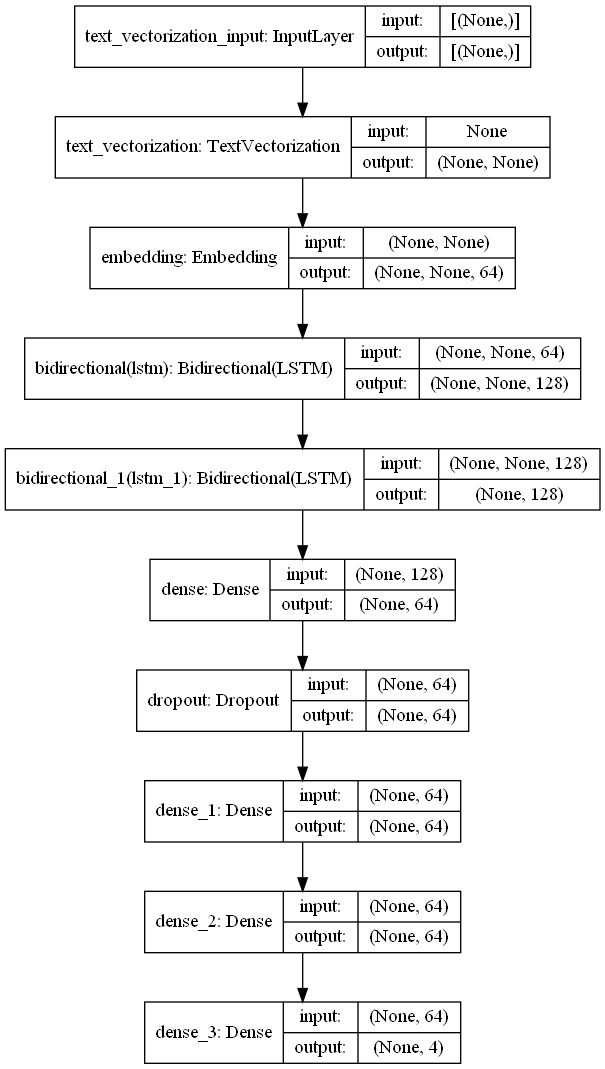

In [24]:
tf.keras.utils.plot_model(model, to_file='wass-lstm.png', show_shapes=True)

### Printing the history parameters

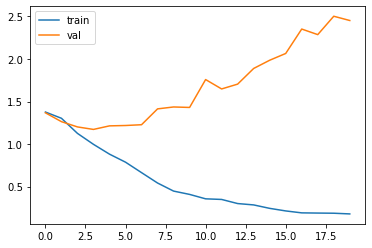

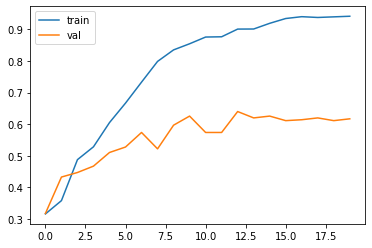

In [25]:
plt.figure(1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

plt.figure(2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

## Evaluation against test

In [26]:
model.evaluate(test_dataset)

25/25 [==============================] - 1s 21ms/step - loss: 2.9039 - accuracy: 0.5611


[2.903893232345581, 0.5611075758934021]

In [27]:
pred = model.predict(test_dataset)

In [28]:
pred_idx = []
target_idx = []

for i in tqdm(range(len(pred))):
    pred_idx.append(np.argmax(pred[i]))
    target_idx.append(y_test[i])

100%|██████████████████████████████████████████████████████████████████████████| 3142/3142 [00:00<00:00, 285675.64it/s]


In [29]:
print(classification_report(target_idx, pred_idx, target_names=parameters['classes']))

              precision    recall  f1-score   support

       anger       0.65      0.46      0.54       760
         joy       0.67      0.63      0.65       714
     sadness       0.41      0.51      0.46       673
        fear       0.56      0.62      0.59       995

    accuracy                           0.56      3142
   macro avg       0.57      0.56      0.56      3142
weighted avg       0.58      0.56      0.56      3142



In [30]:
print(confusion_matrix(target_idx, pred_idx))

[[353  58 149 200]
 [ 25 453 123 113]
 [ 91  71 345 166]
 [ 73  91 219 612]]
